# Simple moving average trading strategy
In this notebook I analyze prices and returns of four major stock. Then I implement a simple moving average trading strategy and back test it using a simple a backtester.

## Portfolio of four major stock

In [1]:
# Importing libraries

import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import quandl
import scipy.optimize as sco
import pyfolio as p
plt.style.use('fivethirtyeight')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/Users/alexandergeiger/opt/anaconda3/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
# Import data for four major stocks from quandl

quandl.ApiConfig.api_key = 'is9J6Gdep3c_XZpxQu8h'
stocks = ['AAPL','AMZN','GOOGL','FB']
data = quandl.get_table('WIKI/PRICES', ticker = stocks,
                        qopts = { 'columns': ['date', 'ticker', 'adj_close'] },
                        date = { 'gte': '2013-1-1', 'lte': '2018-3-26' }, paginate=True)
data.head()

,date,ticker,adj_close
None,,,
0,2018-03-26,GOOGL,1054.09
1,2018-03-23,GOOGL,1026.55
2,2018-03-22,GOOGL,1053.15
3,2018-03-21,GOOGL,1094.00
4,2018-03-20,GOOGL,1095.80


In [3]:
# Transform the dataframe into a more handy format

df = data.set_index ('date')
table = df.pivot(columns = 'ticker')
columns = table.columns.get_level_values(1)
table.columns = columns
table.head()


ticker,AAPL,AMZN,FB,GOOGL
date,,,,
2013-01-02,71.195748,257.3100,28.0000,362.744758
2013-01-03,70.296565,258.4800,27.7700,362.955409
2013-01-04,68.338996,259.1500,28.7600,370.127548
2013-01-07,67.937002,268.4592,29.4213,368.512563
2013-01-08,68.119845,266.3800,29.0607,367.785318


ticker      AAPL      AMZN        FB     GOOGL
ticker                                        
AAPL    0.000228  0.000074  0.000090  0.000072
AMZN    0.000074  0.000335  0.000159  0.000138
FB      0.000090  0.000159  0.000411  0.000132
GOOGL   0.000072  0.000138  0.000132  0.000198


ticker
AAPL     0.000789
AMZN     0.001536
FB       0.001526
GOOGL    0.000909
dtype: float64

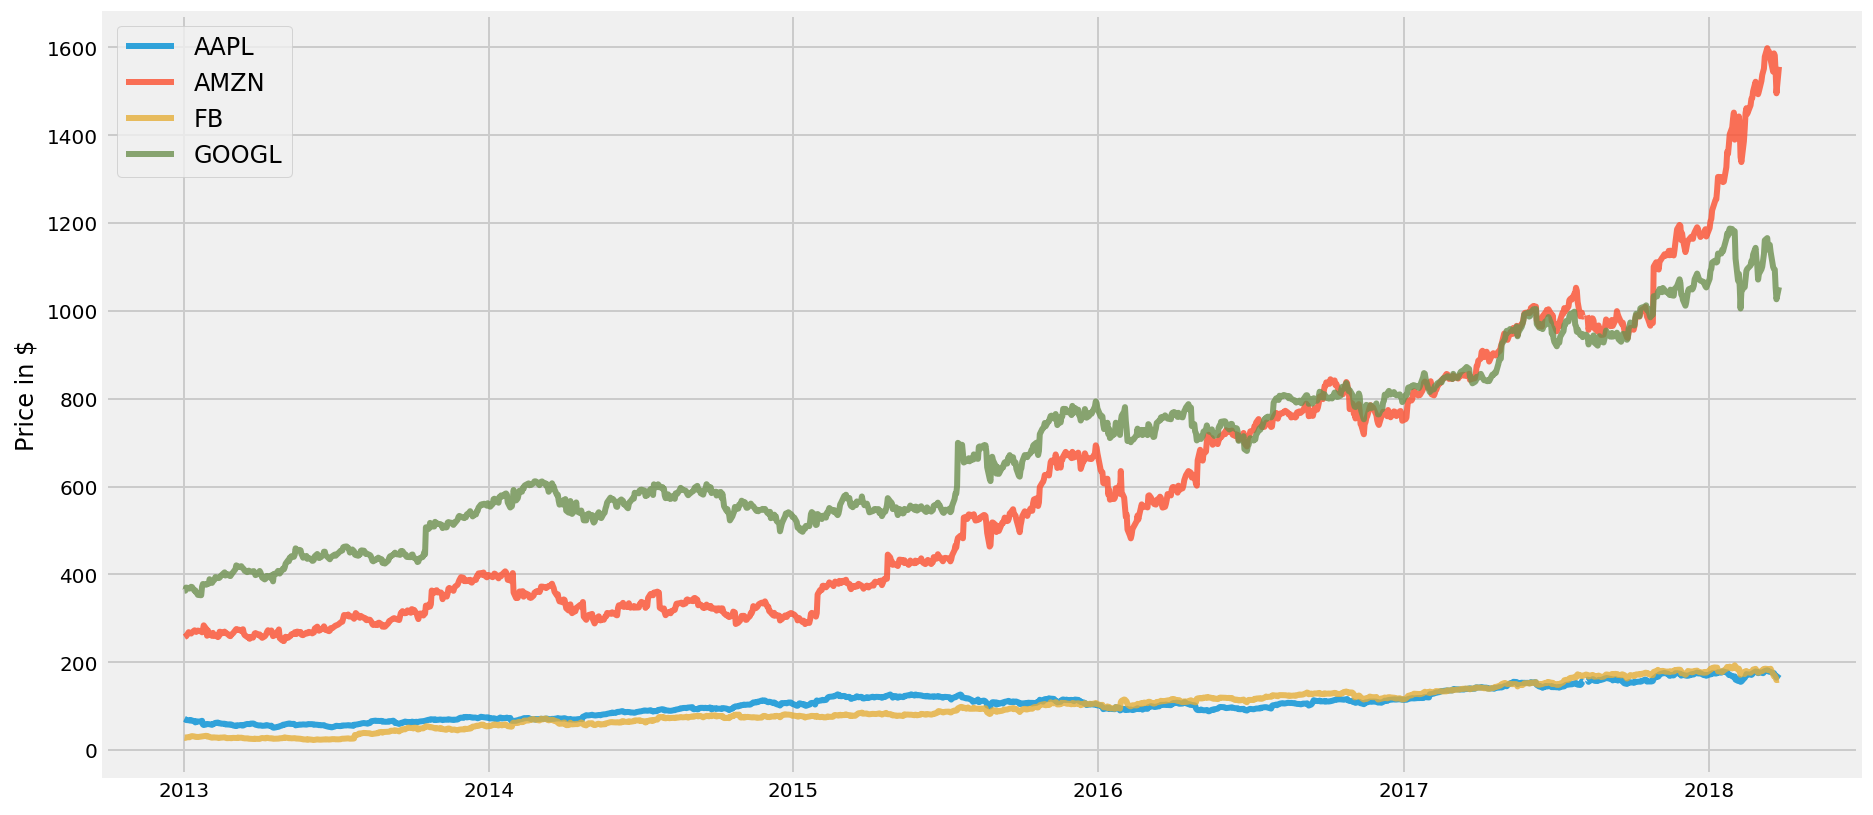

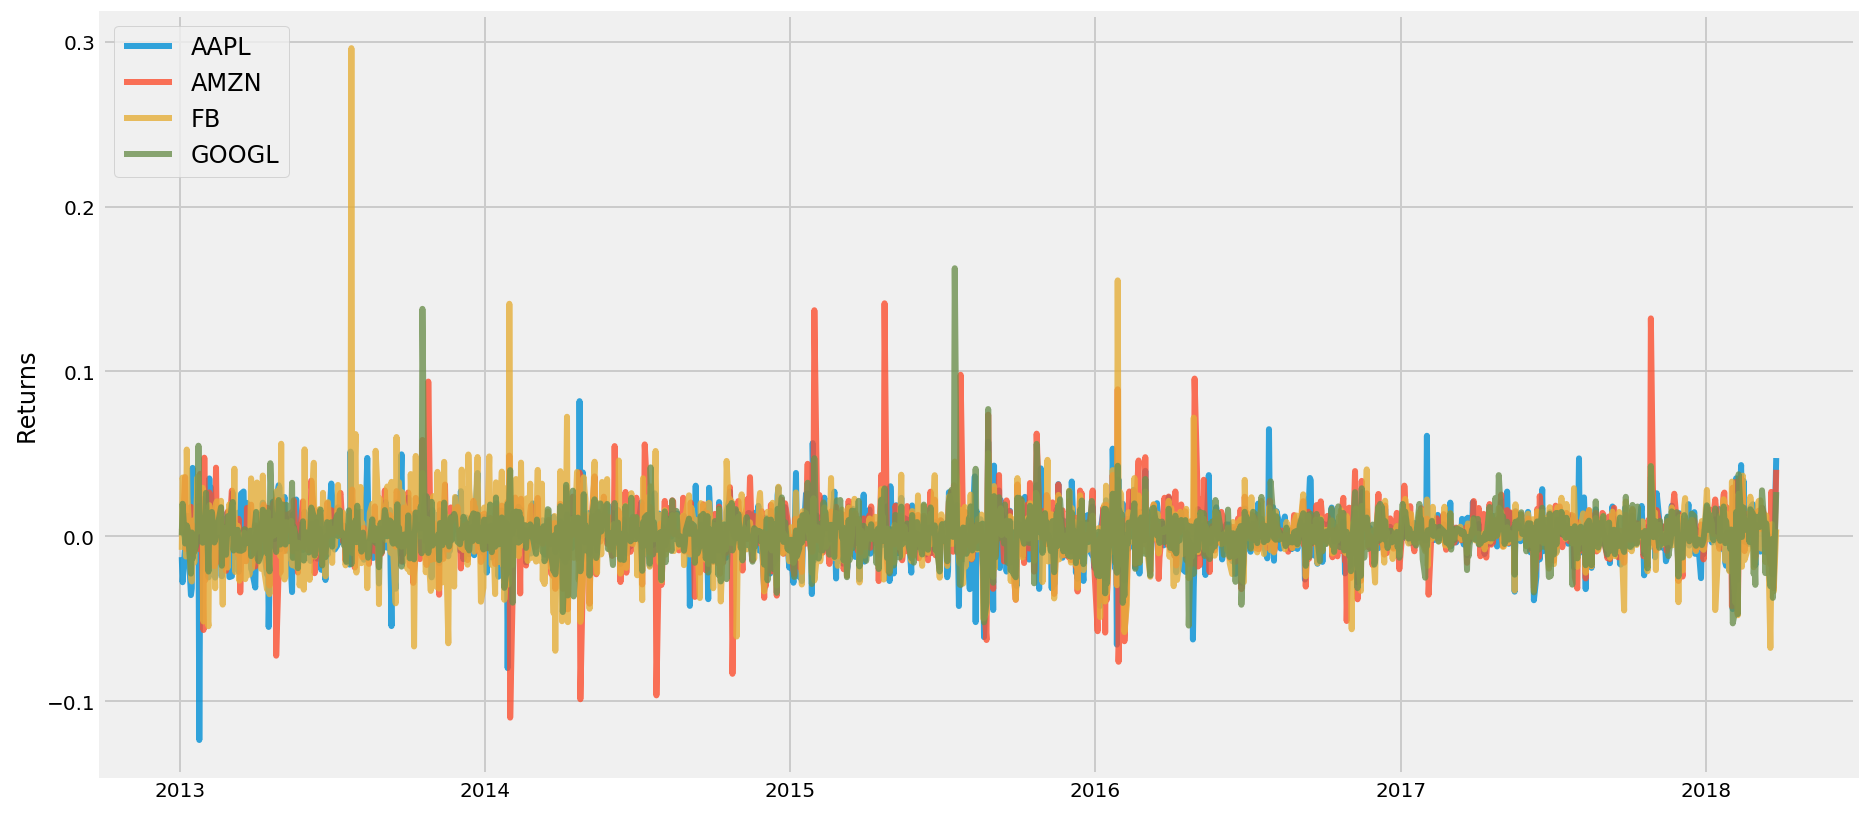

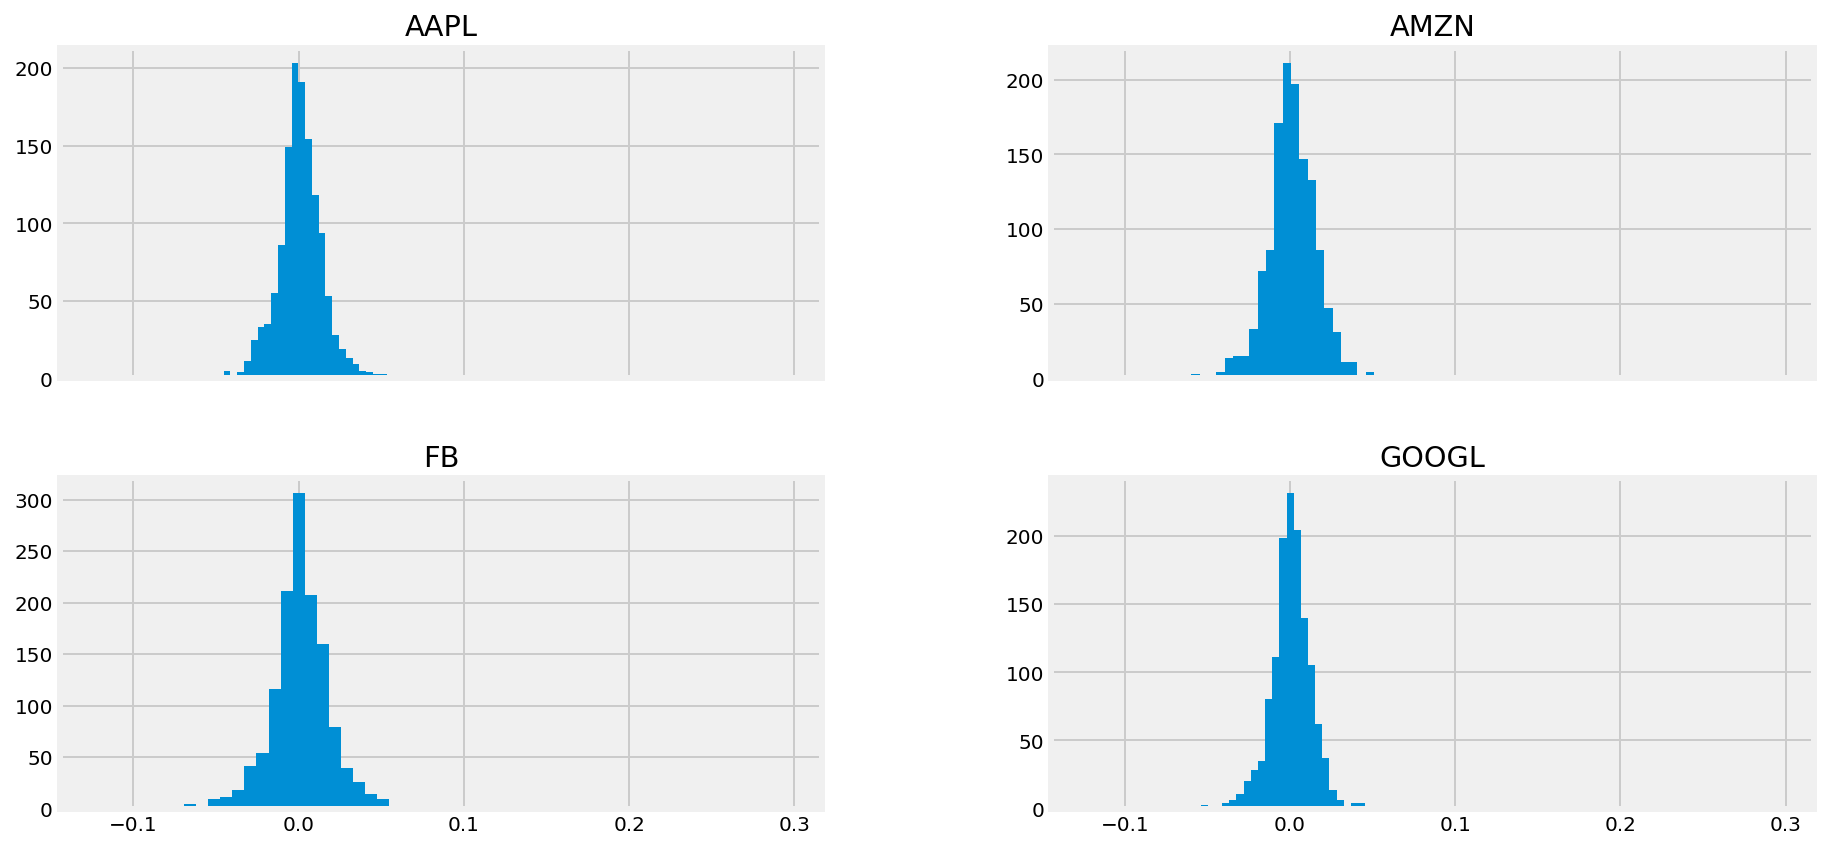

In [4]:
# Plot prices of  stocks

plt.figure(figsize=(14, 7))
for c in table.columns:
    plt.plot(table.index, table[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('Price in $')

# Plot returns of  stocks

returns = table.pct_change()
returns.head()
plt.figure(figsize=(14, 7))
for c in returns.columns:
    plt.plot(returns.index, returns[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('Returns')

# Mean returns
returns.hist(figsize=(14, 7), bins=50, sharex=True)
mean_returns = returns.mean()
cov_matrix = returns.cov()
print(cov_matrix)
mean_returns.head()

Text(0, 0.5, 'Price in $')

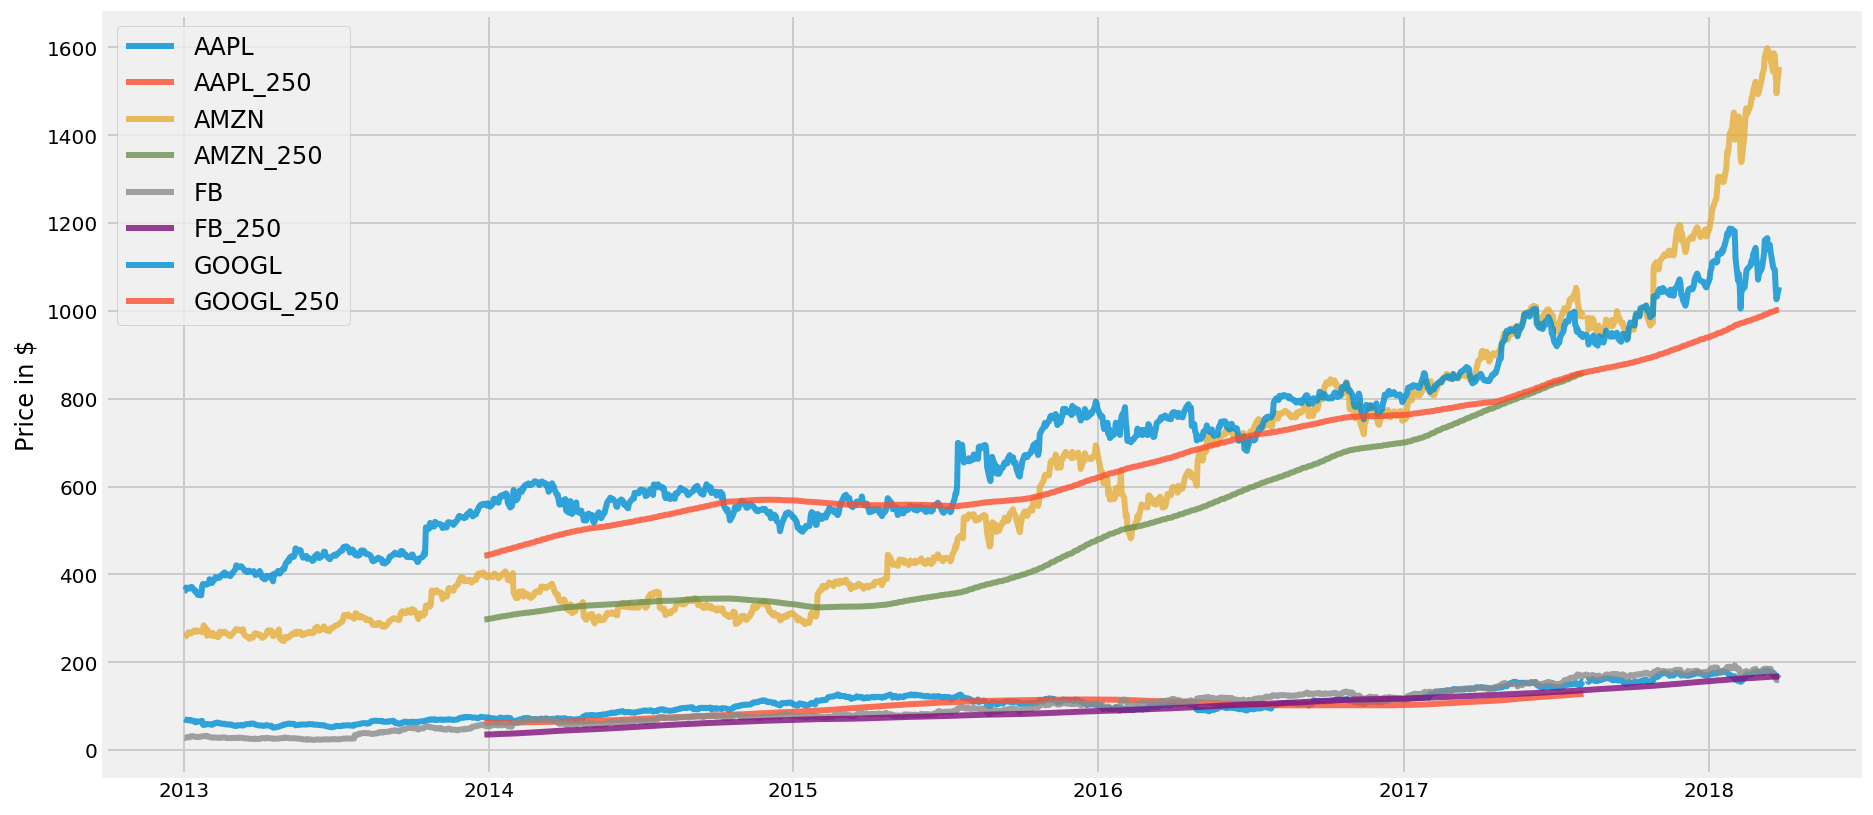

In [5]:
# Plot prices of  stocks

#rol_40 = table.rolling(window=40).mean()
rol_100 = table.rolling(window=100).mean()
rol_250 = table.rolling(window=250).mean()

plt.figure(figsize=(14, 7))
for c in table.columns:
    plt.plot(table.index, table[c], lw=3, alpha=0.8,label=c)
   # plt.plot(rol_40.index, rol_40[c], lw=3, alpha=0.8,label=c+str('_40'))
   # plt.plot(rol_100.index, rol_100[c], lw=3, alpha=0.8,label=c+str('_100'))
    plt.plot(rol_250.index, rol_250[c], lw=3, alpha=0.8,label=c+str('_250'))
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('Price in $')





Text(0, 0.5, 'Returns')

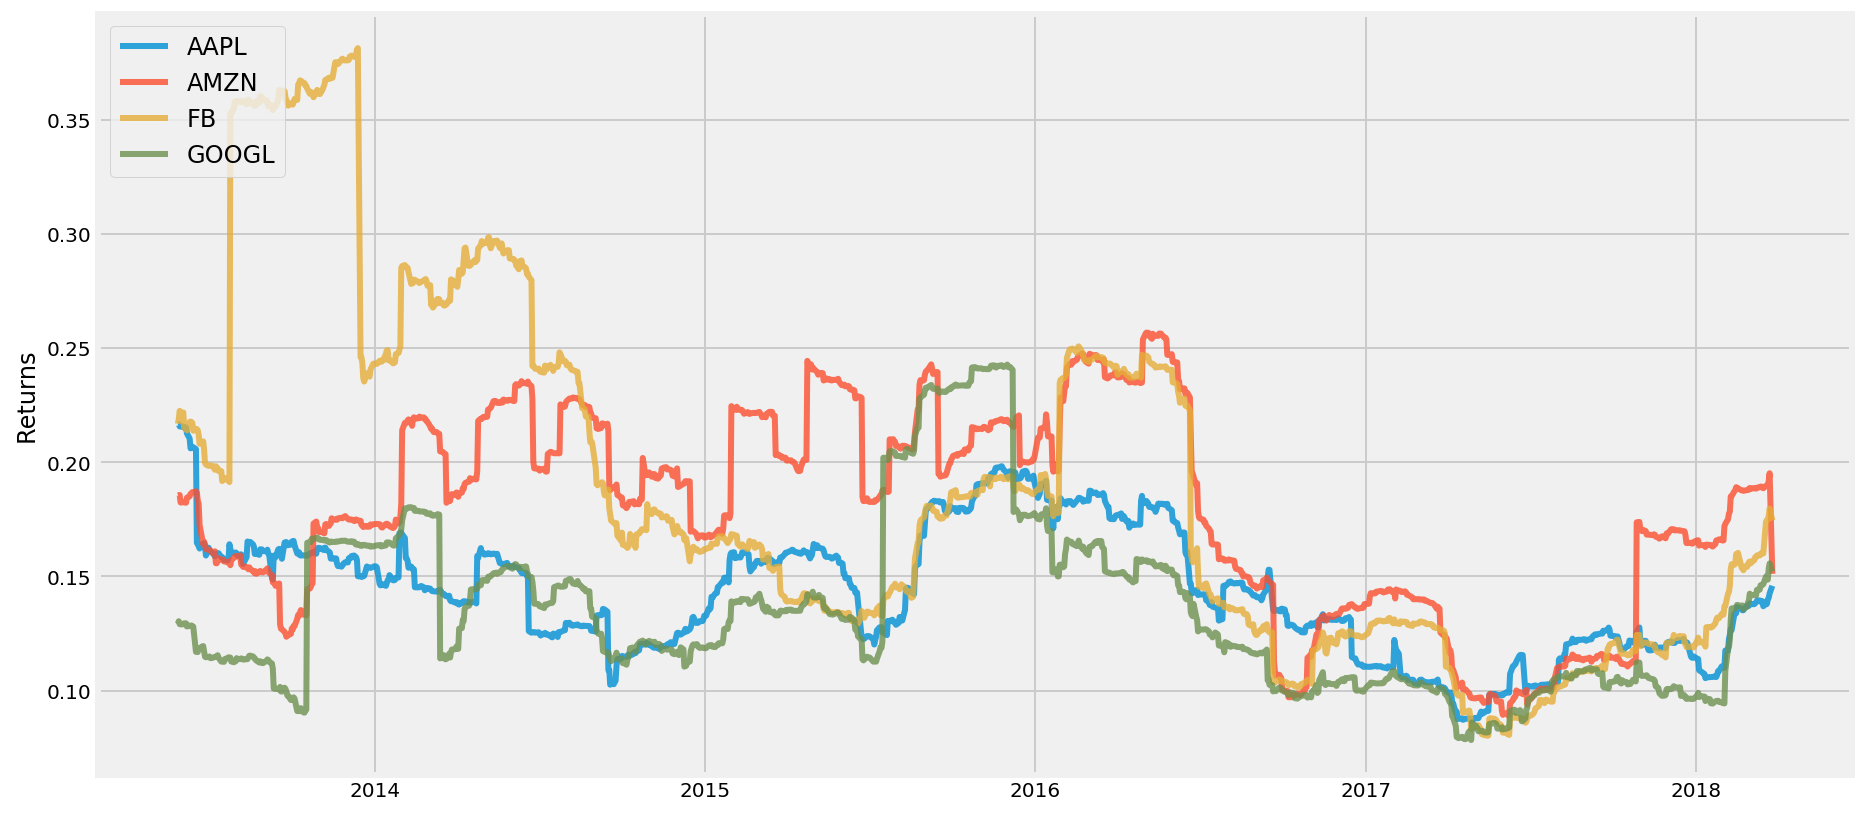

In [6]:
# Define the minumum of periods to consider 
min_periods_100 = 100


plt.figure(figsize=(14, 7))
returns_rol_100 = returns.rolling(min_periods_100).std() * np.sqrt(min_periods_100) 
for i in returns_rol_100.columns:
    plt.plot(returns.index, returns_rol_100[i], lw=3, alpha=0.8, label=i)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('Returns')


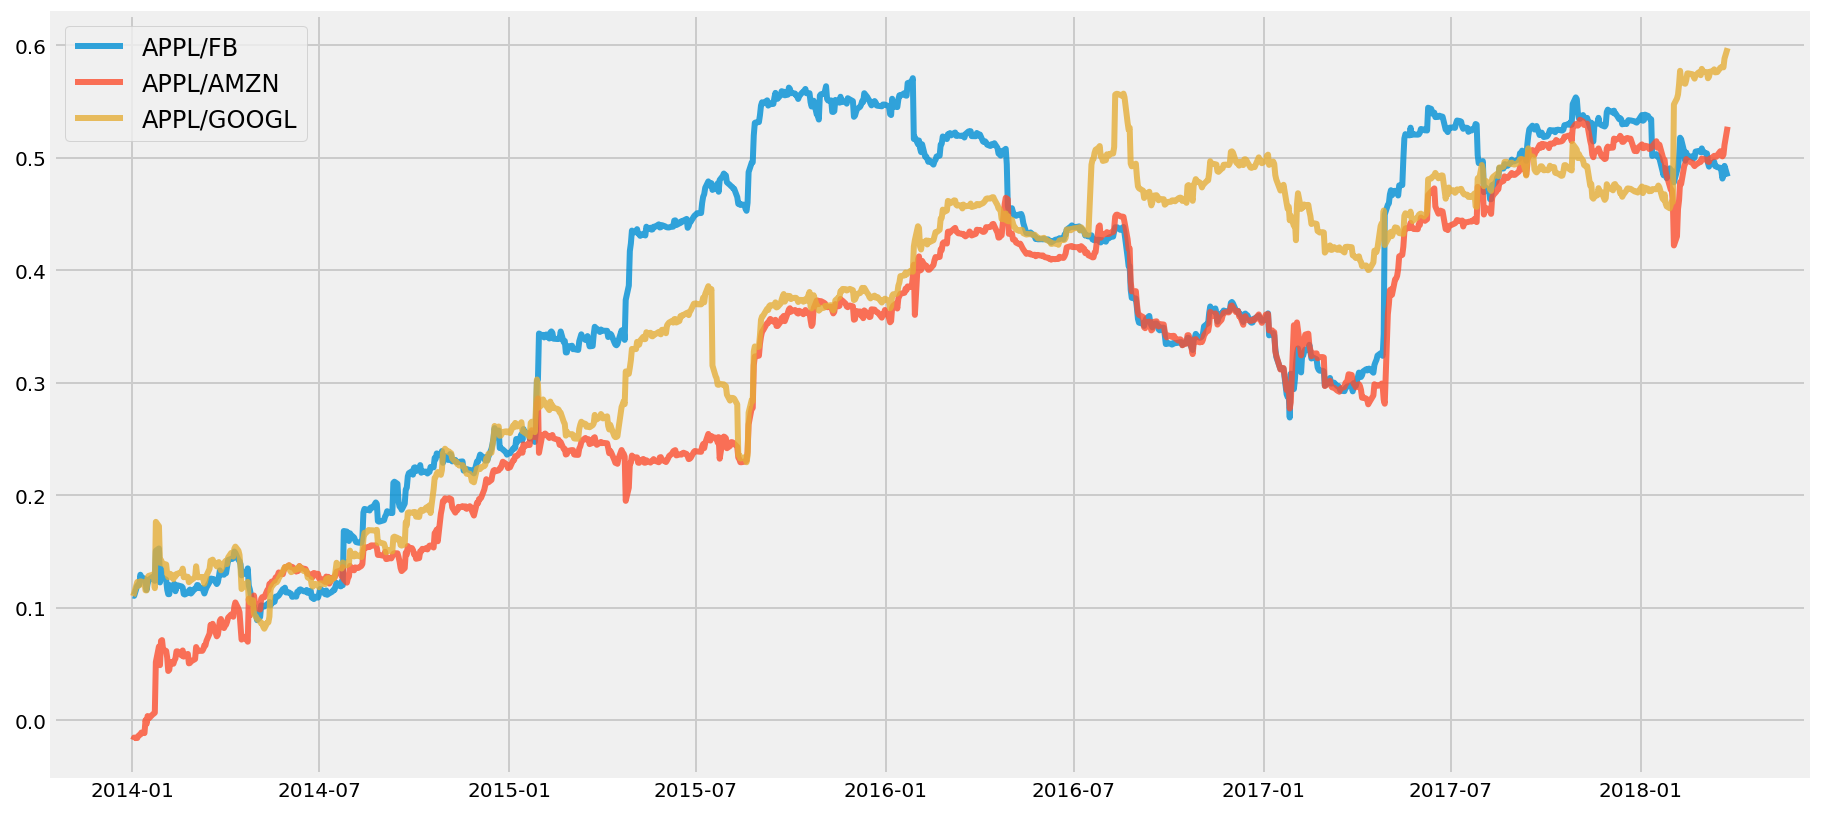

In [7]:
# Rolling correlation

# Plot rolling correlation
roll_corr_1 = returns['AAPL'].rolling(window=252).corr(returns['FB'])
roll_corr_2 = returns['AAPL'].rolling(window=252).corr(returns['AMZN'])
roll_corr_3 = returns['AAPL'].rolling(window=252).corr(returns['GOOGL'])
plt.figure(figsize=(14, 7))
plt.plot(returns.index, roll_corr_1, lw=3, alpha=0.8, label='APPL/FB')
plt.plot(returns.index, roll_corr_2, lw=3, alpha=0.8, label='APPL/AMZN')
plt.plot(returns.index, roll_corr_3, lw=3, alpha=0.8, label='APPL/GOOGL')
plt.legend(loc='upper left', fontsize=12)
# Show the plot
plt.show()

## Simple moving average trading strategy for Apple stock

<Figure size 432x288 with 0 Axes>

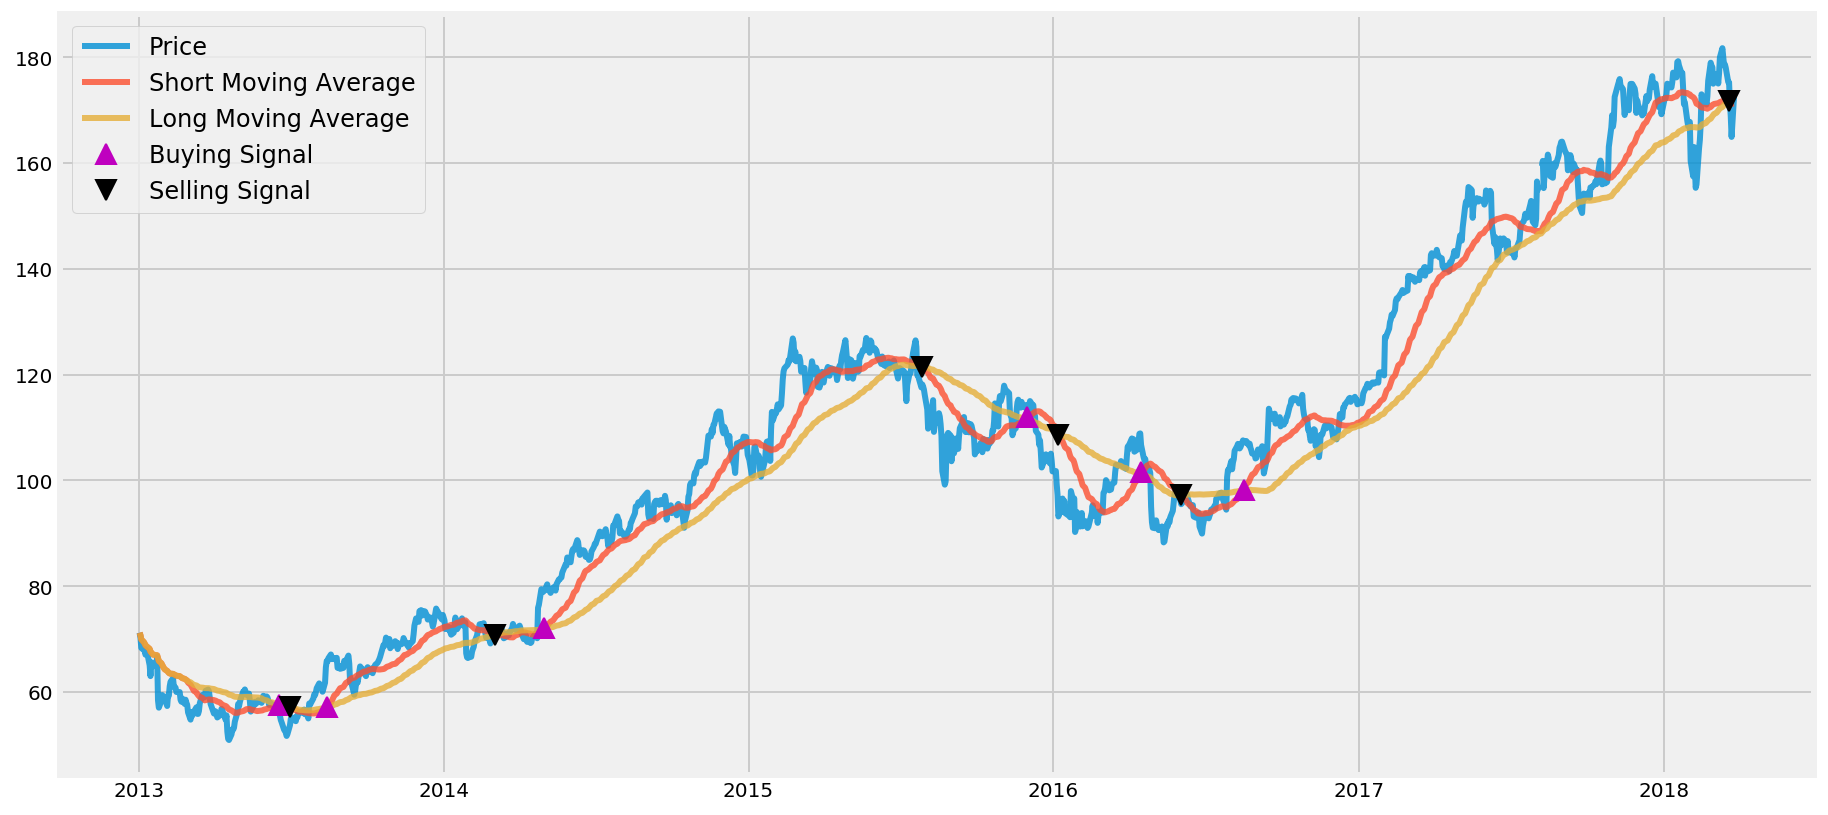

In [9]:
# Define windows
short_window = 40
long_window = 100
pd.options.mode.use_inf_as_na = True

# Calculate rolling mean for AAPL
table['short_mov'] = table['AAPL'].rolling(window=short_window, min_periods=1, center=False).mean()
table['long_mov'] = table['AAPL'].rolling(window=long_window, min_periods=1, center=False).mean()
table['signal'] = 0.0
table['signal'][short_window:] = np.where(table['short_mov'][short_window:] > table['long_mov'][short_window:], 1.0, 0.0)  
table['positions'] = table['signal'].diff()

# Create plots
fig = plt.figure()
plt.figure(figsize=(14, 7))
plt.plot(table.index, table.AAPL, lw=3, alpha=0.8,label='Price')
plt.plot(table.index, table.short_mov, lw=3, alpha=0.8,label='Short Moving Average')
plt.plot(table.index, table.long_mov, lw=3, alpha=0.8,label='Long Moving Average')
plt.plot(table.loc[table.positions == 1.0].index, table.short_mov[table.positions == 1.0], '^', markersize=10, color='m', label = 'Buying Signal')
plt.plot(table.loc[table.positions == -1.0].index, table.short_mov[table.positions == -1.0],'v', markersize=10, color='k', label = 'Selling Signal')                                           
plt.legend(loc='upper left', fontsize=12)

### Simple Backtester

In [17]:
# Set the initial capital
initial_capital= float(100000.0)

# Create a dataframe to store positions
positions = pd.DataFrame(index=table.index).fillna(0.0)

# Buy shares
positions['AAPL'] = 100*table['signal']  
pos_diff = positions.diff()

# Initialize the portfolio dataframe
portfolio = positions.multiply(table['AAPL'], axis=0)
portfolio['holdings'] = positions.multiply(table['AAPL'], axis=0).sum(axis=1)
portfolio['cash'] = initial_capital - (pos_diff.multiply(table['AAPL'], axis=0).sum(axis=1).cumsum())
portfolio['total'] = portfolio['cash'] + portfolio['holdings']
portfolio['returns'] = portfolio['total'].pct_change()
print(portfolio.head())

            AAPL  holdings      cash     total  returns
date                                                   
2013-01-02   0.0       0.0  100000.0  100000.0      NaN
2013-01-03   0.0       0.0  100000.0  100000.0      0.0
2013-01-04   0.0       0.0  100000.0  100000.0      0.0
2013-01-07   0.0       0.0  100000.0  100000.0      0.0
2013-01-08   0.0       0.0  100000.0  100000.0      0.0


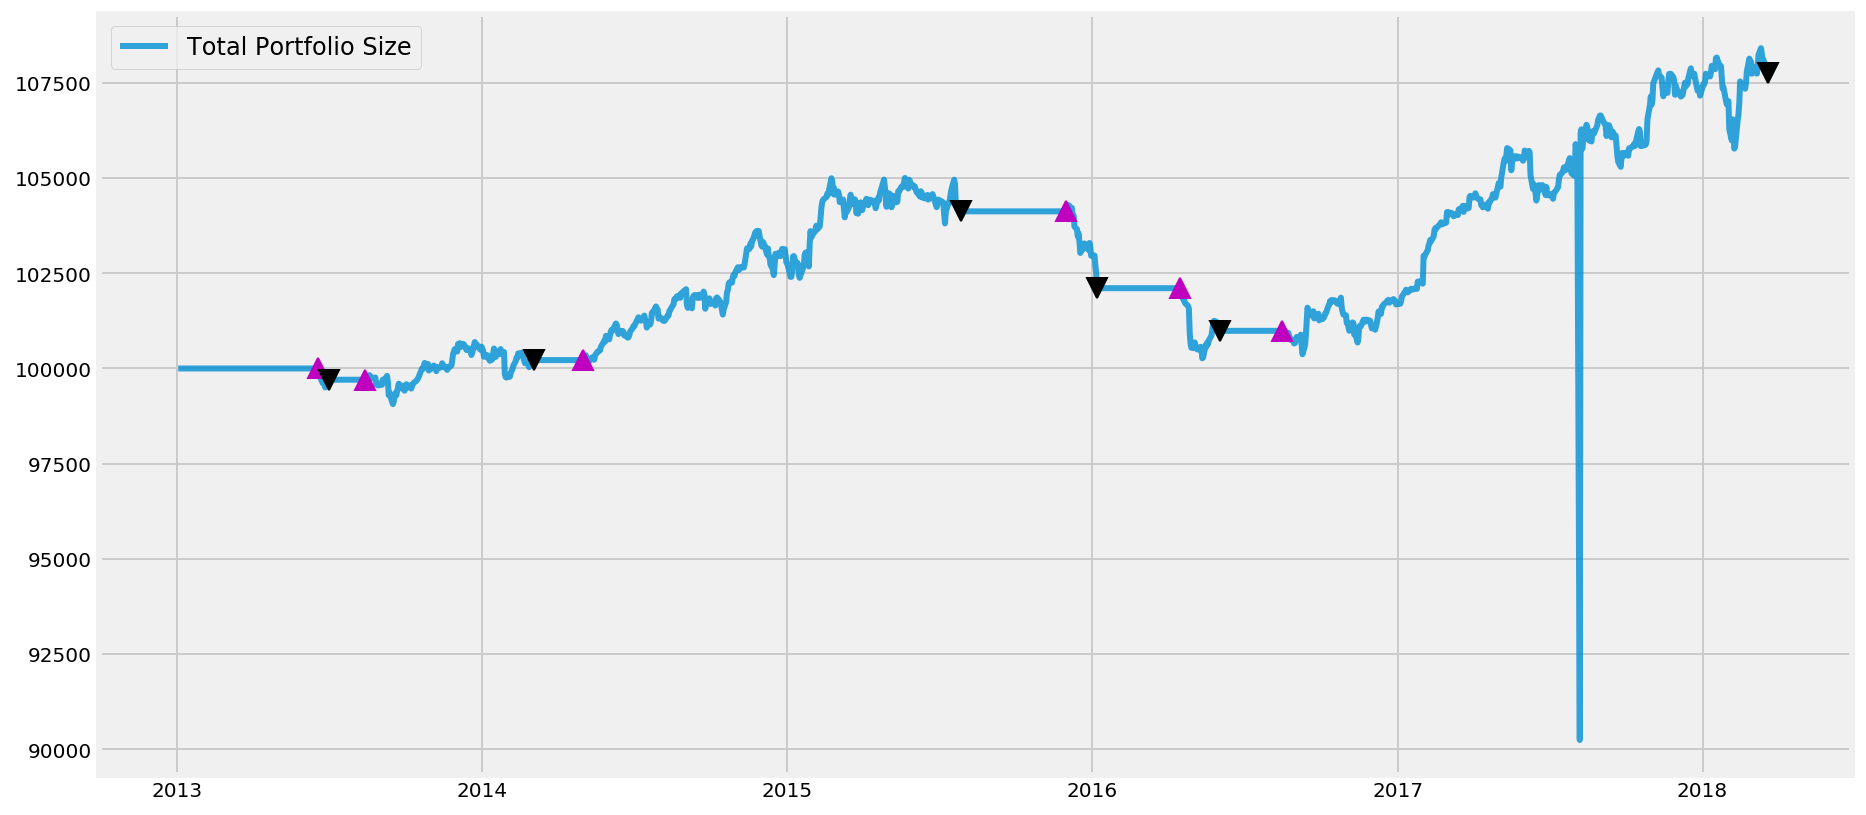

In [23]:
# Plot the equity curve in dollars
plt.figure(figsize=(14, 7))
plt.plot(table.index, portfolio['total'],lw=3, alpha=0.8,label='Total Portfolio Size' )
plt.plot(portfolio.loc[table.positions == 1.0].index, portfolio.total[table.positions == 1.0], '^', markersize=10, color='m')
plt.plot(portfolio.loc[table.positions == -1.0].index,  portfolio.total[table.positions == -1.0], 'v', markersize=10, color='k')
plt.legend(loc='upper left', fontsize=12)
